### Setup

In [2]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_model import ValueModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [5]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Look at Value Model performance in same time interval

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


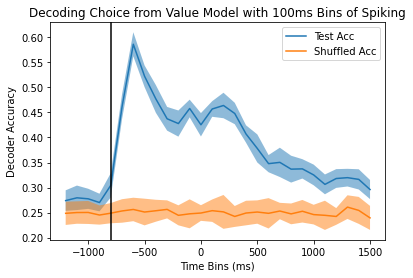

In [4]:
pre_interval = 1300
post_interval = 1500

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

np.save(fs.open(f"l2l.pqz317.scratch/value_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/value_model_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/value_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/value_model_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### Look at how different aggregation functions compare

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


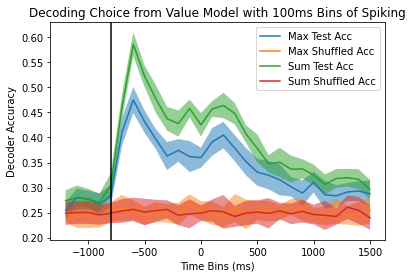

In [5]:
pre_interval = 1300
post_interval = 1500

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.max}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

np.save(fs.open(f"l2l.pqz317.scratch/value_model_max_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/value_model_max_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/value_model_max_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/value_model_max_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))


sum_test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
sum_shuffled_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Max Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Max Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    sum_test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    sum_shuffled_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### Split Trials by Figured Out, Not figured Out

In [11]:
figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)
print(f"Number of Figured Out trials: {len(figured_out)}")
print(f"Number of Not Figured Out trials: {len(not_figured_out)}")

Number of Figured Out trials: 592
Number of Not Figured Out trials: 1157


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

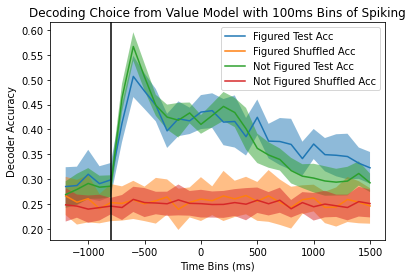

In [13]:
pre_interval = 1300
post_interval = 1500

figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]
figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(figured_out.TrialNumber)]
figured_splitter = RandomSplitter(figured_labels.TrialNumber.unique(), 20, 0.2)

not_figured_inputs = inputs[inputs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_splitter = RandomSplitter(not_figured_labels.TrialNumber.unique(), 20, 0.2)

figured_test_accs, figured_shuffled_accs, figured_models, figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, figured_inputs, figured_labels, np.arange(0, 2.8, 0.1), figured_splitter, cards=figured_card_idxs
)

not_figured_test_accs, not_figured_shuffled_accs, not_figured_models, not_figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, not_figured_inputs, not_figured_labels, np.arange(0, 2.8, 0.1), not_figured_splitter, cards=not_figured_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### Figured, Not Figured, Different Agg Funcs

In [5]:
# prep data for classification
pre_interval = 1300
post_interval = 1500

mode = "SpikeCounts"

figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)

inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]
figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(figured_out.TrialNumber)]
figured_splitter = RandomSplitter(figured_labels.TrialNumber.unique(), 20, 0.2)

not_figured_inputs = inputs[inputs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_splitter = RandomSplitter(not_figured_labels.TrialNumber.unique(), 20, 0.2)

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
trainer = Trainer(learning_rate=0.05, max_iter=1000)

#### Figured Out: Compare Max, Sum

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

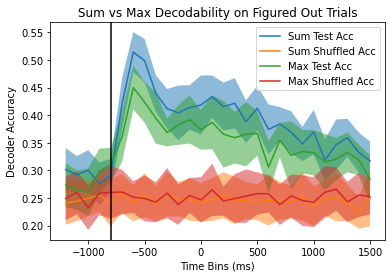

In [8]:
init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.sum}
sum_wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.max}
max_wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)


sum_figured_test_accs, sum_figured_shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
    sum_wrapped, figured_inputs, figured_labels, np.arange(0, 2.8, 0.1), figured_splitter, cards=figured_card_idxs
)

max_figured_test_accs, max_figured_shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
    max_wrapped, figured_inputs, figured_labels, np.arange(0, 2.8, 0.1), figured_splitter, cards=figured_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    sum_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    sum_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    max_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Max Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    max_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Max Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Sum vs Max Decodability on Figured Out Trials")
ax.legend()

#### Not Figured Out: Compare Max, Sum

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

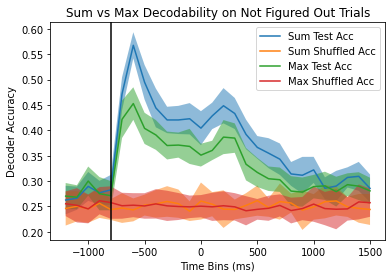

In [6]:
init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.sum}
sum_wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.max}
max_wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)


sum_not_figured_test_accs, sum_not_figured_shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
    sum_wrapped, not_figured_inputs, not_figured_labels, np.arange(0, 2.8, 0.1), not_figured_splitter, cards=not_figured_card_idxs
)

max_not_figured_test_accs, max_not_figured_shuffled_accs, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
    max_wrapped, not_figured_inputs, not_figured_labels, np.arange(0, 2.8, 0.1), not_figured_splitter, cards=not_figured_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    sum_not_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    sum_not_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Sum Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    max_not_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Max Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    max_not_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Max Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Sum vs Max Decodability on Not Figured Out Trials")
ax.legend()

### Look at Cross Decodeability of Value Model

Text(0.5, 1.0, 'Value Model Mean Accuracies Across Timebins')

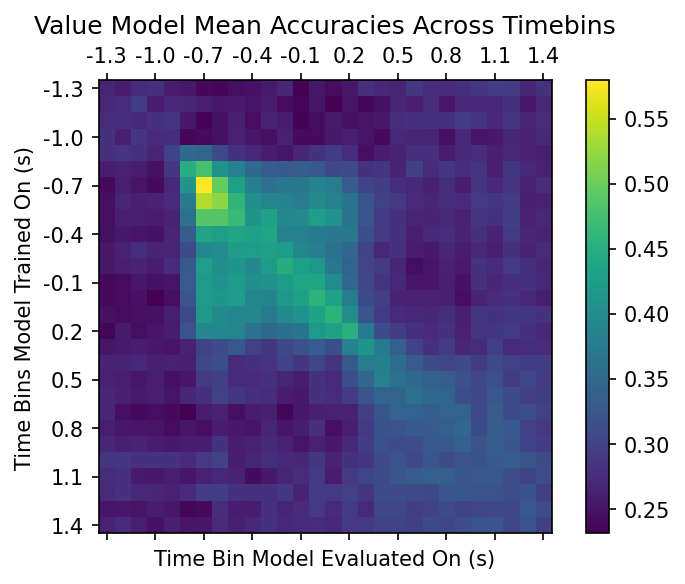

In [40]:
models = np.load(fs.open(f"l2l.pqz317.scratch/value_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
splits = pickle.load(fs.open(f"l2l.pqz317.scratch/value_model_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))


mode = "SpikeCounts"

inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

bins = np.arange(0, 2.8, 0.1)

cross_accs = classifier_utils.cross_evaluate_by_time_bins(models, inputs, labels, splits, bins, shuffled_card_idxs)

np.save(fs.open(f"l2l.pqz317.scratch/value_model_cross_decodability.npy", "wb"), cross_accs)

fig, ax = plt.subplots()
colors = ax.matshow(cross_accs)
fig.colorbar(colors)
axis = np.arange(0, 28, 3)
labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(axis)
ax.set_yticks(axis)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Time Bin Model Evaluated On (s)")
ax.set_ylabel("Time Bins Model Trained On (s)")
ax.set_title(f"Value Model Mean Accuracies Across Timebins")

### What about during cross fixation?

In [14]:
pre_interval = 300
post_interval = 500

firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_crossfixation_{post_interval}_100_bins.pickle"))


In [15]:
figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)
print(f"Number of Figured Out trials: {len(figured_out)}")
print(f"Number of Not Figured Out trials: {len(not_figured_out)}")

Number of Figured Out trials: 592
Number of Not Figured Out trials: 1157


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001


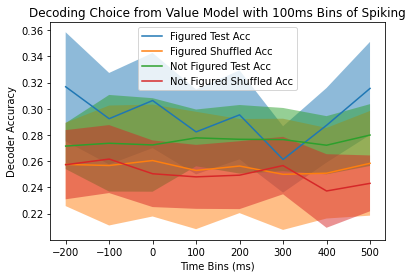

In [18]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]
figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(figured_out.TrialNumber)]
figured_splitter = RandomSplitter(figured_labels.TrialNumber.unique(), 20, 0.2)

not_figured_inputs = inputs[inputs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_splitter = RandomSplitter(not_figured_labels.TrialNumber.unique(), 20, 0.2)

figured_test_accs, figured_shuffled_accs, figured_models, figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, figured_inputs, figured_labels, np.arange(0, 0.8, 0.1), figured_splitter, cards=figured_card_idxs
)

not_figured_test_accs, not_figured_shuffled_accs, not_figured_models, not_figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, not_figured_inputs, not_figured_labels, np.arange(0, 0.8, 0.1), not_figured_splitter, cards=not_figured_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Shuffled Acc",
    right_align=True
)

ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### What about cross fixation multiple intervals?

In [19]:
pre_interval = 300
post_interval = 500

firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_crossfixation_{post_interval}_100_bins.pickle"))


In [20]:
figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)
print(f"Number of Figured Out trials: {len(figured_out)}")
print(f"Number of Not Figured Out trials: {len(not_figured_out)}")

Number of Figured Out trials: 592
Number of Not Figured Out trials: 1157


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


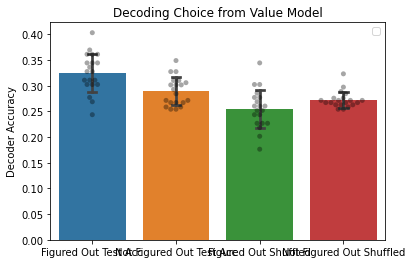

In [22]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons * 8, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=8000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]
figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(figured_out.TrialNumber)]
figured_splitter = RandomSplitter(figured_labels.TrialNumber.unique(), 20, 0.2)

not_figured_inputs = inputs[inputs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_splitter = RandomSplitter(not_figured_labels.TrialNumber.unique(), 20, 0.2)

figured_train_accs, figured_test_accs, figured_shuffled_accs, figured_models = classifier_utils.evaluate_classifier(
    wrapped, figured_inputs, figured_labels, figured_splitter, cards=figured_card_idxs
)

not_figured_train_accs, not_figured_test_accs, not_shuffled_accs, not_figured_models = classifier_utils.evaluate_classifier(
    wrapped, not_figured_inputs, not_figured_labels, not_figured_splitter, cards=not_figured_card_idxs
)
accs = [
    figured_test_accs,
    not_figured_test_accs,
    figured_shuffled_accs,
    not_figured_shuffled_accs,
]
labels= [
    "Figured Out Test Acc",
    "Not Figured Out Test Acc",
    "Figured Out Shuffled",
    "Not Figured Out Shuffled"
]

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_bars(
    accs,
    labels,
    ax,
)
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model")
ax.legend()

### Look at weights of the model

In [6]:
temp_units = spike_utils.get_temporal_drive_unit_ids(fs, subject, session)
ant_units = spike_utils.get_anterior_drive_unit_ids(fs, subject, session)

temp_then_ant = np.concatenate((temp_units, ant_units))

# get spike count variances per unit
unit_vars = spike_utils.get_variances_for_units(firing_rates)
spike_count_vars = unit_vars.SpikeCountVar
spike_count_vars = spike_count_vars[:, None]

/tmp/ipykernel_1363678/311398304.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_vars = spike_count_vars[:, None]


(28,)


Text(0.5, 1.0, 'Value Decoders Weights Across Timebins')

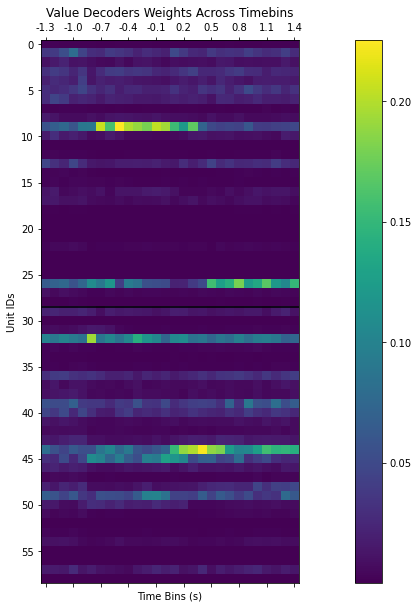

In [11]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
models = np.load(fs.open(f"l2l.pqz317.scratch/value_model_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)
weights = weights.T
var_accounted = weights * spike_count_vars

sums = np.sum(var_accounted, axis=0)
print(sums.shape)

normalized = var_accounted / np.sum(var_accounted, axis=0)
# reorder by temp then ant
# reordered = normalized[temp_then_ant, :]

fig, ax = plt.subplots(figsize=(20, 10))
colors = ax.matshow(normalized)
fig.colorbar(colors)
axis = np.arange(0, 28, 3)
labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(axis)
ax.set_xticklabels(labels)
ax.set_xlabel("Time Bins (s)")
y_axis = np.arange(0, 59, 5)
ax.set_ylabel("Unit IDs")
ax.set_yticks(y_axis)
ax.set_yticklabels(y_axis)
ax.axhline(len(temp_units) - 0.5, color='k')

ax.set_title(f"Value Decoders Weights Across Timebins") 

In [16]:
cool_units = [9, 26, 32, 44, 45, 49]
list = spike_general.list_session_units(fs, subject, session)


In [18]:
cool_list = list[list["UnitID"].isin(cool_units)]

In [20]:
list

,UnitID,Channel,Unit,SpikeTimesFile
0,0,103,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
1,1,103,2,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
2,2,107,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
3,3,108,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
4,4,109,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
5,5,109,2,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
6,6,109,3,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
7,7,10a,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
8,8,114,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
9,9,116,1,nhp-lfp/wcst-preprocessed/rawdata/sub-SA/sess-...
